# Classification

## 1. Introduction
Classification is a predictive modeling problem where a given input data is assigned to a class. The main types of classification probelms are binary, multi-class, and multi-label. The present project is a multi-class classification where each article is assigned to a topic area. The topic-areas include:

|  | Class label | number of articles |
| :-- | :-- | :-- |
| 1 | business | 244422|
| 2 | general | 84921|
| 3 | finance | 22386|
| 4 | tech | 8676|
| 5 | science | 3478|
| 6 | consumer | 1451|
| 7 | healthcare | 1340|
| 8 | automotive | 925|
| 9 | environment | 777|
| 10 | construction | 305|
| 11 | ai | 239|

Since the number of articles per class is not unifrormly distributed the dataset is unblanaced, extra considerations are required to address this issue. Generally, A stratightforward answer on how to map algorithms onto problem types do not exist. And, it is usually recommended that a practitioner use controlled experiments and discover which algorithm and algorithm configuration results in the best performance for a given classification task.

For this project I use the following steps to evaluate various methods of classifications:
1. Experiment with a prototype:
    * Select a subset of dataset for protoyping
    * Implement various classification algorithms
        * *NaiveBayes*
        * *Logistic Regression*
        * *Stochastic Gradient Descent*
        * *Support Vector Machine*
    * Select appropriate classification methods for the dataset
2. Extend the analysis to the entire dataset
    * Merge topic areas with low samples to reduce the impact of unbalance in the dataset
    * Apply BayesSearchCV to select the suitable hyper-parameters
    * Select the best performing classification model as the basis of comparison for the DL model 


In [ ]:
# IMPORT THE REQUIRED LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import time
from pprint import pprint
import dill as pickle
from sklearn.utils.fixes import loguniform

# Model selection
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Model optimization
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

from sklearn.utils import class_weight

# Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.svm import SVC

# performance metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

## 2. Performance Evluation Functions 
I defined some fuctions to claculate the classifications scores and plot the results. The fuctions will be extensively used in the notebook to assess the performance of each model.

### 2.1. Encode labels
We can use onehotencoder or label encoder to transform the labels. However, scikit learn can digest text labels and I will use text labels for now. The script below will be used if I need encoded labels in the future.

In [58]:
def label_enc(array):
    enc = LabelEncoder()
    #y = df_majority.topic_area.values
    array = enc.fit_transform(array)
    n_classes = len(enc.classes_[0])
    return array, n_classes

In [59]:
def ordinal_enc(array):
    enc = OrdinalEncoder()
    #y = df_majority.topic_area.values
    array = enc.fit_transform(array.reshape(-1,1))
    n_classes = len(enc.categories_[0])
    return array, n_classes

In [60]:
def onehot_enc(array):
    enc = OneHotEncoder()
    #y = df_majority.topic_area.values.reshape(-1,1)
    array = enc.fit_transform(array.reshape(-1,1)).toarray()
    n_classes = len(enc.categories_[0])
    #print((enc.categories_))
    return array, n_classes, enc.categories_[0]

### 2.2. ROC Curve for Multiclass Classification

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

I use the following function to generate ROC curve for the exisitng multi-class problem.

In [50]:
def roc_calc(y_test, y_pred_prob):
    
    y_test_enc, n_classes, categories = onehot_enc(y_test)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_enc[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc, categories

In [51]:
def roc_plot(fpr, tpr, roc_auc, categories):
    lw = 2
        
    fig = plt.figure(figsize=(10,30))
    for i in range(len(categories)):
        ax = fig.add_subplot(6,2,i+1)
        ax.plot(fpr[i], tpr[i], color='r',
         lw=lw, label='ROC curve - (area = %0.2f)' % roc_auc[i])
        ax.plot([0, 1], [0, 1], color='b', lw=lw, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title("Receiver operating characteristic - {}".format(categories[i]))
        ax.legend(loc="lower right")
        ax.plot()

### 2.3. Precision Recall Curve

Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.

The precision_recall_curve computes a precision-recall curve from the ground truth label and a score given by the classifier by varying a decision threshold. I use the follwoing function to calculate and plot the precision and recall for the existing multi-class problem.

In [52]:
# For each class
def pre_rec_calc(y_test, y_pred_prob):
    
    y_test_enc, n_classes, _ = onehot_enc(y_test)
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_enc[:, i], y_pred_prob[:, i])
        average_precision[i] = average_precision_score(y_test_enc[:, i], y_pred_prob[:, i])
    
    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_test_enc.ravel(), y_pred_prob.ravel()
    )
    average_precision["micro"] = average_precision_score(y_test_enc, y_pred_prob, average="micro")
    
    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot()
    _ = display.ax_.set_title("Micro-averaged over all classes")
    
    return precision, recall, average_precision

In [53]:
# setup plot details
def pre_rec_plot(precision, recall, average_precision):
    
    y_test_enc, n_classes, categories = onehot_enc(y_test)
    
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])
    
    _, ax = plt.subplots(figsize=(7, 8))
    
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))
        
    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")
        
    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {categories[i]}", color=color)
    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Extension of Precision-Recall curve to multi-class")
    
    plt.show()

## 3. Experimenting with a Prototype
In this section I will import the transformed word vector from the previous notebook. I used the Tfidf with maximum 1000 features to vectorize the pre-processed text. Each article has a topic-area that was defiend in the original dataset.

In [ ]:
df = pd.read_csv('../data/interim/covid_articles_tfidf.csv')
df.head()

In [3]:
df.topic_area.value_counts()

business        244422
general          84921
finance          22386
tech              8676
science           3478
consumer          1451
healthcare        1340
automotive         925
environment        777
construction       305
ai                 239
Name: topic_area, dtype: int64

Since the number of articles per topic area are not balanced, I will filter out the tags with low frequency. Alternatively, I may merge the excluded tags with the closest tag with higher frequency.

In [4]:
min_samples = 10000

filter_topics = df['topic_area'].value_counts().to_frame()
filter_topics = filter_topics[filter_topics['topic_area']>min_samples].index
df_majority = df[df['topic_area'].isin(filter_topics)].drop(columns='title')
print(df_majority.shape)
df_majority.head()

(351729, 1001)


,topic_area,ability,able,accelerate,access,accord,accordance,account,accounting,achieve,...,worker,world,worth,would,write,year,yet,yield,york,young
0,business,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.03,0.02,0.12,0.03,0.11,0.00,0.0
1,business,0.03,0.00,0.0,0.0,0.04,0.0,0.0,0.0,0.0,...,0.06,0.00,0.0,0.02,0.03,0.17,0.00,0.12,0.00,0.0
2,business,0.00,0.02,0.0,0.0,0.02,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.11,0.02,0.05,0.08,0.00,0.00,0.0
6,business,0.00,0.03,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.00,0.0,0.04,0.03,0.09,0.04,0.00,0.04,0.0
7,general,0.00,0.03,0.0,0.0,0.21,0.0,0.0,0.0,0.0,...,0.03,0.05,0.0,0.02,0.00,0.03,0.00,0.00,0.00,0.0


### 3.1. Train and Test Data

In [12]:
X = df_majority.drop(columns='topic_area')
y = df_majority.topic_area.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

## 3.2. Classifiers
I will apply NaiveBayes, Logistic Regression, SGD, and SVM classifiers on the data.

#### 3.2.1. Naive Bayes

In [13]:
# Naive Bayes
clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)
y_pred = clf_nb.predict(X_test)
y_pred_prob = clf_nb.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    business       0.84      0.83      0.84     73389
     finance       0.67      0.00      0.01      6628
     general       0.61      0.78      0.68     25502

    accuracy                           0.77    105519
   macro avg       0.70      0.54      0.51    105519
weighted avg       0.77      0.77      0.75    105519



The results indicate that the model struggles to classifiy the under-represented class. The recall score of 0.00 for finance class indicates that almost none of the finance aricles could be correctly classified. The recall score for "general" topic is more acceptable. 

To further clarify this challenge I plotted the ROC curve and the precsion-recall curve for all classes.

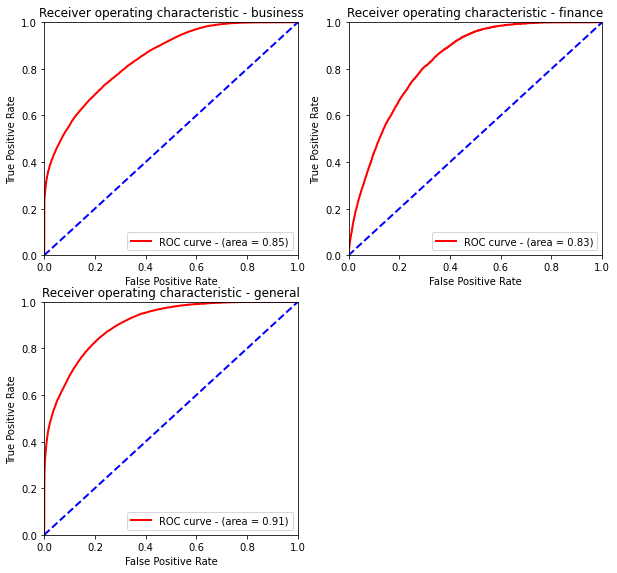

In [14]:
fpr, tpr, roc_auc, categories = roc_calc(y_test, y_pred_prob)
roc_plot(fpr, tpr, roc_auc, categories)

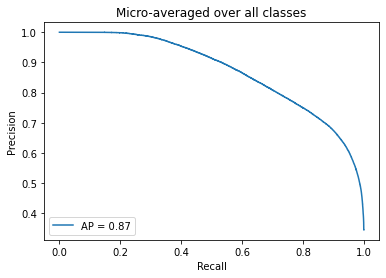

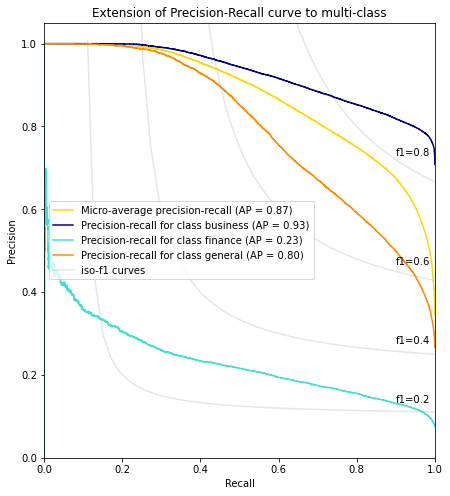

In [15]:
precision, recall, average_precision = pre_rec_calc(y_test, y_pred_prob)
pre_rec_plot(precision, recall, average_precision)

#### 3.2.2. Logistic Regression
Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

In [16]:
clf_lr = LogisticRegression(solver='liblinear')
clf_lr.fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)
y_pred_prob = clf_lr.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    business       0.87      0.96      0.91     73389
     finance       0.75      0.30      0.43      6628
     general       0.87      0.75      0.80     25502

    accuracy                           0.86    105519
   macro avg       0.83      0.67      0.71    105519
weighted avg       0.86      0.86      0.85    105519



The logistic regression had a higher performance compared with the NaiveBayes model for the classification of articles in the existing dataset. The recall score for the "finance" class has improved, which means the model could correctly classifiy one third of finance articles. The f1-score for the two other classes has improved as well.

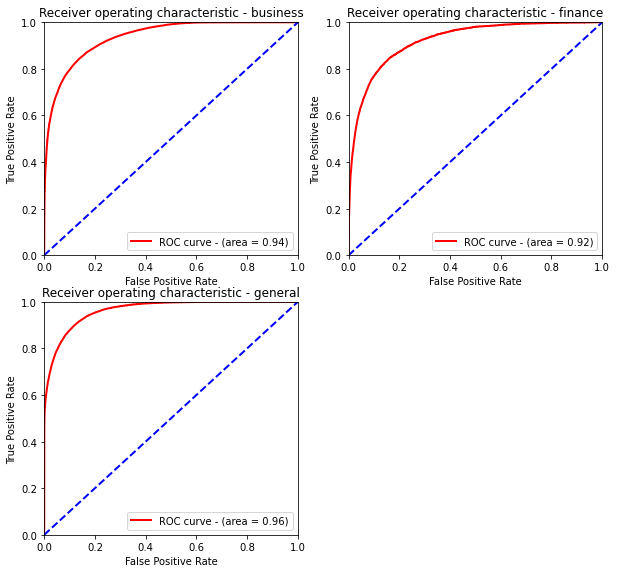

In [17]:
fpr, tpr, roc_auc, categories = roc_calc(y_test, y_pred_prob)
roc_plot(fpr, tpr, roc_auc, categories)

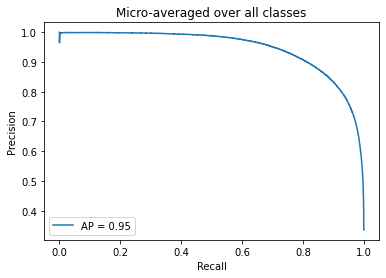

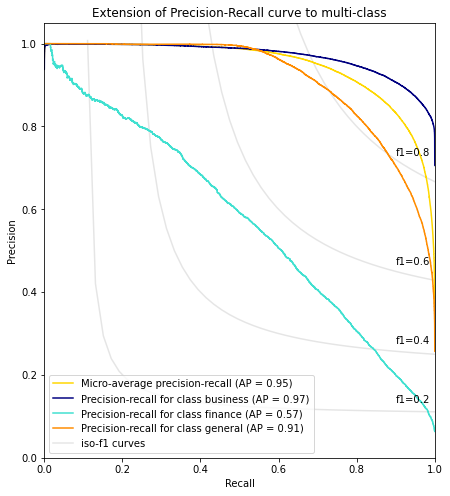

In [18]:
precision, recall, average_precision = pre_rec_calc(y_test, y_pred_prob)
pre_rec_plot(precision, recall, average_precision)

#### 3.2.3. SGD Classifier

In [19]:
clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
clf_sgd.fit(X_train, y_train)
y_pred = clf_sgd.predict(X_test)

print(classification_report(y_test, y_pred))

C:\Users\rasaee\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    business       0.80      1.00      0.89     73389
     finance       0.00      0.00      0.00      6628
     general       1.00      0.52      0.69     25502

    accuracy                           0.82    105519
   macro avg       0.60      0.51      0.52    105519
weighted avg       0.79      0.82      0.78    105519



The model has a very poor performance in classification of the under-represented classes. Therefore, I will not proceed with further analysis using SGD for the existing dataset.

#### 3.3.4. SVM Classifier
SVC and NuSVC implement the “one-versus-one” approach for multi-class classification. In total, n_classes * (n_classes - 1) / 2 classifiers are constructed and each one trains data from two classes. To provide a consistent interface with other classifiers, the decision_function_shape option allows to monotonically transform the results of the “one-versus-one” classifiers to a “one-vs-rest” decision function of shape (n_samples, n_classes).

In [38]:
from sklearn.svm import SVC

clf_svm = SVC(decision_function_shape='ovo')
clf_svm.fit(X_train, y_train)

SVC(decision_function_shape='ovo')

In [40]:
y_pred = clf_svm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    business       0.90      0.97      0.94     73389
     finance       0.91      0.50      0.64      6628
     general       0.92      0.81      0.86     25502

    accuracy                           0.90    105519
   macro avg       0.91      0.76      0.81    105519
weighted avg       0.91      0.90      0.90    105519



So far, the SVM had the highest performance for the classification of the articles. I used the One-vs-One (ovo) shape fuctions which fits one binary classification model for each pair of classes. While the results are encouraging the model too a long time for the training phase. Since, I was working with a subset of the articles and feature space, it would be very challenging to extend this method to the whole dataset. I will save the model for reference, but will not use that in the next step.

In [44]:
"""
# save the model to disk
filename = '../models/svm_model.sav'
pickle.dump(clf_svm, open(filename, 'wb'))

# load the model from disk
clf_svm_loaded = pickle.load(open(filename, 'rb'))
"""

"\n# save the model to disk\nfilename = '../models/svm_model.sav'\npickle.dump(clf_svm, open(filename, 'wb'))\n\n# load the model from disk\nclf_svm_loaded = pickle.load(open(filename, 'rb'))\n"

## 4. Using the Entire Dataset to Develop the Baseline Model
To study the hyperparameter space and improve model performance, I created a pipeline to put all these steps together and find an optimum hyperparamter space.

### 4.1. Class Weights
Giving different weights to both the majority and minority classes is a way deal with imbalanced data. The weights will impact the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class.

In [42]:
def class_weight_gen(y_train):
    weights_classes = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    weight_dict = dict(zip(np.unique(y_train), weights_classes))
    weights = [weight_dict[x] for x in y_train]
    return weights

### 4.2. Hyperparameter Tuning and Optimization Search
Two generic approaches to parameter search are provided in scikit-learn: for given values, GridSearchCV exhaustively considers all parameter combinations, while BaysianSearchCV can sample a given number of candidates from a parameter space with a specified distribution.

#### 4.2.1. BayesSearchCV
BayesSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings.

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

Parameters are presented as a list of skopt.space.Dimension objects.

In [43]:
def bayes_search_cv(pipeline, param_grid, fit_params=None, n_iter=50):
    
    search = BayesSearchCV(estimator=pipeline, search_spaces=param_grid,
                           fit_params=fit_params, n_iter=n_iter, n_jobs=5, verbose=1, random_state=21)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(param_grid)
    t0 = time.time()
    
    search.fit(X_train, y_train)
    #print("done in %0.3fs" % (time() - t0))
    print()
    
    print("Best score: %0.3f" % search.best_score_)
    print("Best parameters set:")
    best_parameters = search.best_estimator_.get_params()
    
    for param_name in sorted(param_grid.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    y_pred = search.predict(X_test)
    y_pred_prob = search.predict_proba(X_test)
    
    print(classification_report(y_test, y_pred))
    
    fpr, tpr, roc_auc, categories = roc_calc(y_test, y_pred_prob)
    roc_plot(fpr, tpr, roc_auc, categories)
    
    precision, recall, average_precision = pre_rec_calc(y_test, y_pred_prob)
    pre_rec_plot(precision, recall, average_precision)

### 4.3. Reading Pre-processed Articles
The cleaned text from previous step is loaded into this notebook for the assessment of vectorization perfromance. I combined the vectorization step and modeling in a pipeline to investigate the potential performance gain by hyper-parameter tuning at each step.

Since the prototype analysis indicated that the models had difficulty with under-represented classes, I merge the topic areas with low samples to create fewer classes with higher number of samples. 

At this time, I merged the topic-areas using my own judgement. In future steps I may revise this assumption by using a topic modeling approach.

In [54]:
# Read the data
df_normal_text = pd.read_csv('../data/interim/covid_articles_normalized.csv')
"""
# Minimum number of samples per class. Only classes that pass this threshold will be included in the model. 
min_samples = 10000

filter_topics = df_normal_text['topic_area'].value_counts().to_frame()
filter_topics = filter_topics[filter_topics['topic_area']>min_samples].index
df_select_topics = df_normal_text[df_normal_text['topic_area'].isin(filter_topics)].drop(columns='title')
"""

## Merge Tags

tag_map = {'consumer':'general',
           'healthcare':'science',
           'automotive':'business',#'industry',
           'environment':'science',
           'construction':'business',#'industry',
           'ai':'tech'}

df_normal_text['tags'] = [(lambda tags: tag_map[tags] if tags in tag_map.keys() else tags)(tags)
                          for tags in df_normal_text['topic_area']]
df_normal_text.tags.value_counts()

business    245652
general      86372
finance      22386
tech          8915
science       5595
Name: tags, dtype: int64

In [55]:
# Split train and test data
#X = df_select_topics.content.tolist()
#y = df_select_topics.topic_area.values

X = df_normal_text.content.tolist()
y = df_normal_text.tags.values


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=21)

### 4.4. NaiveBayes
NaiveBayes did not have a high performance with the subset data. However, I included that in this part to investigate possible performance gains with hyperparamater tuning. 

Initially, I had the ngram_range in my analysis, but it loads too much data into the memory that can't be handeled by my computer. Therefore, I had to exclude it from the analysis.

In [61]:
## Model Specifications
# Parameter grid
param_grid = {
    'clf__alpha': (1e-4, 1.0, "log-uniform"),
    #'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__max_features': [10000, 30000, None],
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__min_df': (3, 5, 10),
    'tfidf__use_idf': (True, False),
}

# Pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

# Crossvalidations
cv = 5

# Fit parameters
fit_params = {'clf__sample_weight':[None, class_weight_gen(y_train)],}

# Number of iterations: Number of parameter settings that are sampled.
n_iter = 32


Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (0.0001, 1.0, 'log-uniform'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': [10000, 30000, None]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished
C:\Users\rasaee\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.9min finished



Best score: 0.748
Best parameters set:
	clf__alpha: 1.0
	tfidf__use_idf: False
	vect__max_df: 1.0
	vect__max_features: None


C:\Users\rasaee\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    business       0.80      0.85      0.82     73696
     finance       1.00      0.00      0.00      6716
     general       0.62      0.77      0.69     25912
     science       0.90      0.01      0.01      1678
        tech       0.00      0.00      0.00      2674

    accuracy                           0.75    110676
   macro avg       0.66      0.32      0.30    110676
weighted avg       0.75      0.75      0.71    110676



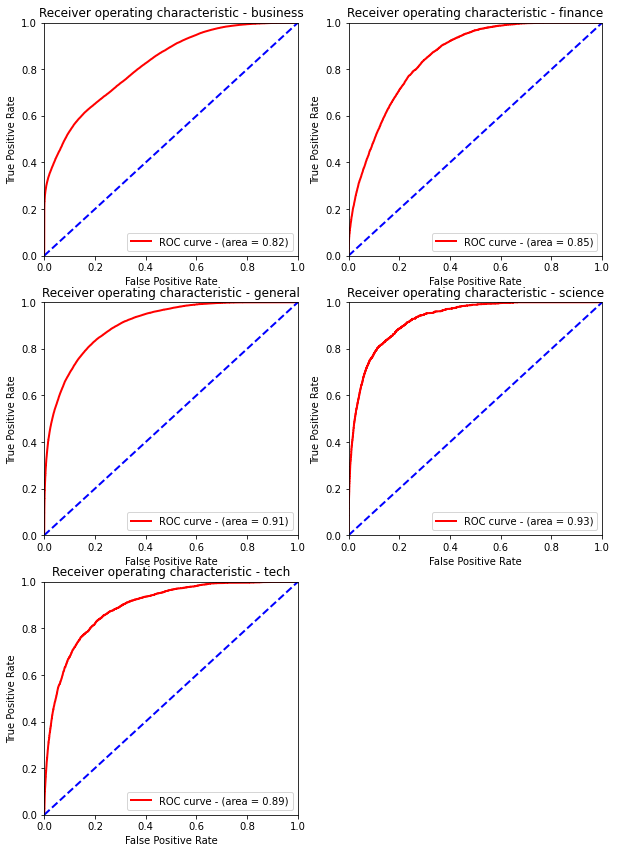

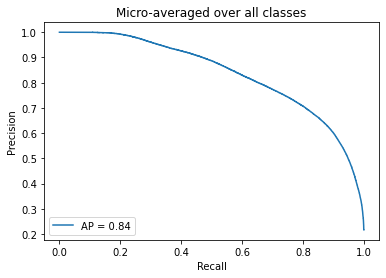

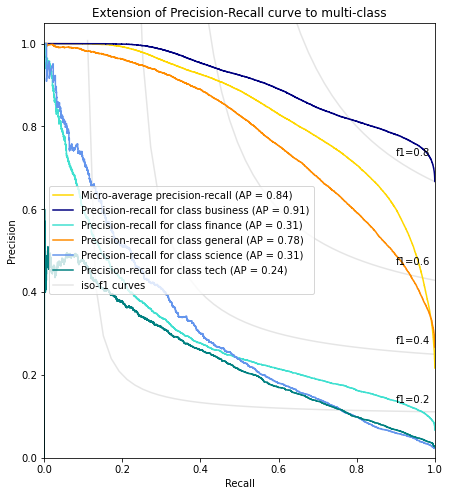

In [62]:
# Execute bayesian search
bayes_search_cv(pipeline, param_grid, fit_params=None, n_iter=n_iter)

Although, a wide range of values for vectorization and NaiveBayes model were used, the model struggles to classify the classes with lower number of data points. It is proven that the low performance of NaiveBayes in this project is associated with the imbalance in the dataset.

### 4.5. Logistic Regression
I used the liblinear solver for the logistic regression to avoid an error associated with the scikit-learn library trying to decode an already decoded string. Also, as discussed above I had to excluded ngram_range from the analysis due to lack of memory.

In [63]:
## Model Specifications
# Parameter grid
param_grid_lr = {
    #'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__max_features': [10000, 30000, None],
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__min_df': (3, 5, 10),
    'tfidf__use_idf': (True, False),
    'clf__dual': (True,False),
    'clf__max_iter': [100,110,120,130,140],
    'clf__C': (1e-5, 1e2, "log-uniform"),
}

# Pipeline
pipeline_lr = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='liblinear', n_jobs=5))
])

# Crossvalidations
cv = 5

# Fit parameters
fit_params = {'clf__sample_weight':[None, class_weight_gen(y_train)],}

# Number of iterations: Number of parameter settings that are sampled.
n_iter = 32

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__C': (1e-05, 100.0, 'log-uniform'),
 'clf__dual': (True, False),
 'clf__max_iter': [100, 110, 120, 130, 140],
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': [10000, 30000, None]}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.4min remaining:  5.2min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  4.3min remaining:  6.5min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.3min remaining:  4.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.2min remaining:  4.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 17.2min remaining: 25.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 19.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.9min remaining: 10.4min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  7.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.6min remaining:  8.3min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.3min remaining:  5.0min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 14.5min remaining: 21.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 16.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 19.0min remaining: 28.5min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 20.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  9.1min remaining: 13.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 10.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.4min remaining:  8.1min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  4.3min remaining:  6.4min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.8min remaining: 10.2min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  7.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 11.1min remaining: 16.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 12.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.1min remaining:  9.1min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  8.6min remaining: 12.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 10.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.0min remaining:  9.0min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 11.6min remaining: 17.5min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 13.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.1min remaining:  9.1min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  7.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  7.3min remaining: 11.0min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  7.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.0min remaining:  4.5min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 23.7min remaining: 35.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 26.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 13.1min remaining: 19.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 14.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.8min remaining:  5.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.5min remaining:  5.2min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  4.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 13.6min remaining: 20.4min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 15.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  7.3min remaining: 10.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  7.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.9min remaining: 10.4min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  7.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  7.3min remaining: 11.0min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  7.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.1min remaining:  4.7min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.7min finished
C:\Users\rasaee\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn("'n_jobs' > 1 does not have any effect when"



Best score: 0.877
Best parameters set:
	clf__C: 33.63295708080422
	clf__dual: False
	clf__max_iter: 110
	tfidf__use_idf: False
	vect__max_df: 1.0
	vect__max_features: 30000
              precision    recall  f1-score   support

    business       0.89      0.95      0.92     73696
     finance       0.80      0.55      0.65      6716
     general       0.87      0.83      0.85     25912
     science       0.74      0.51      0.60      1678
        tech       0.75      0.52      0.61      2674

    accuracy                           0.88    110676
   macro avg       0.81      0.67      0.73    110676
weighted avg       0.87      0.88      0.87    110676



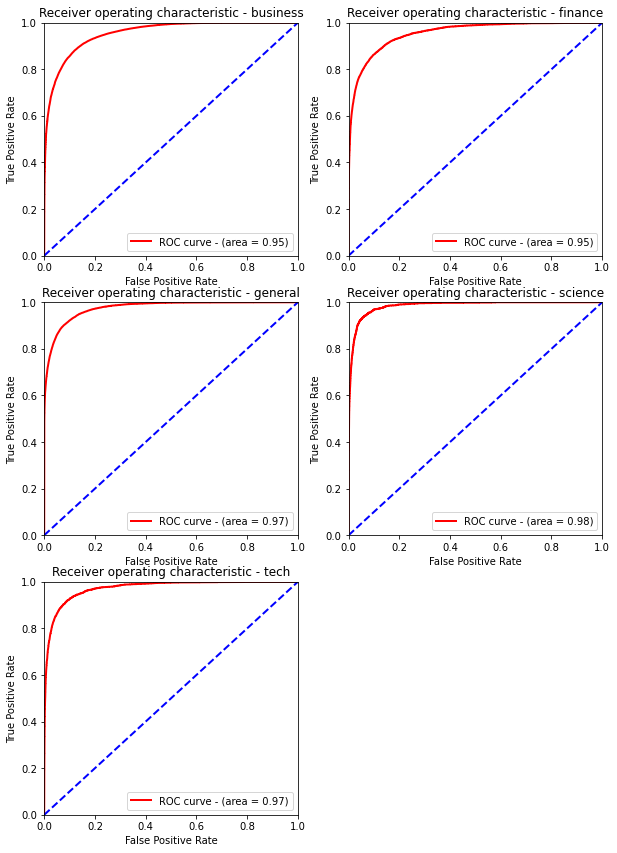

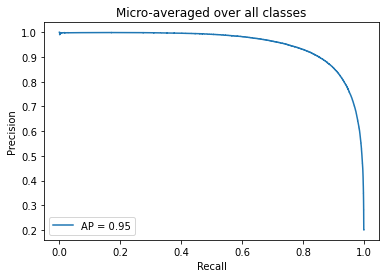

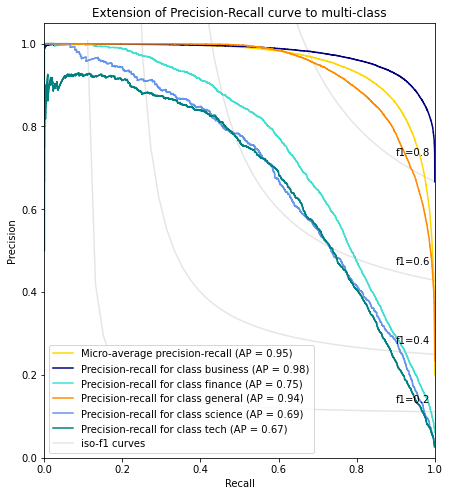

In [64]:
# Execute bayes search with logistic regression
bayes_search_cv(pipeline_lr, param_grid_lr, fit_params=None, n_iter=n_iter)

Hyperparameter tuning had a noticeable impact on the performance of the logistic regression model. The recall for the finance class is almost doubled. The f1-score also shows imporvement compared with the prototype model. The precision and recall score for the added classes are comparable with the scores of the finance class. All these classes have fewer samples compared with the "bussines" class. I believe the current results are the among the best scores that can be achieved with classical ML algorithms for the exisitng dataset. In the next phase I will use DL models and will use these results for comparison.